# Oil Seep Detection Exercise - Machine Learning Engineer

## Libraries: Importing helpful libraries

In [1]:
import os
import cv2
import torch
import random
import numpy as np
from torch import nn
from tqdm import tqdm
import torch.optim as optim
import albumentations as albu
import torch.nn.functional as F
from matplotlib import pyplot as plt
from torch.optim import lr_scheduler
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

SEED = 41
os.environ["PYTHONHASSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Dataset overview: Show a cherry-picked image with its mask

Text(0.5, 1.0, 'Mask')

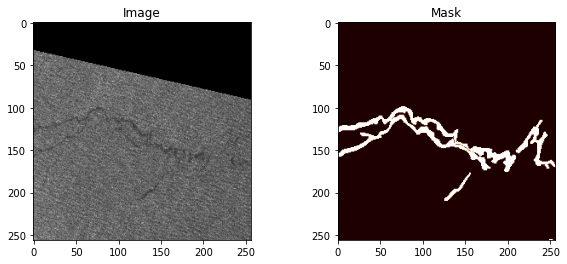

In [2]:
img = cv2.imread('data/train_images_256/041869.000004.tif')
mask = cv2.imread('data/train_masks_256/041869.000004.tif')

fig, axes = plt.subplots(figsize=(10,4), ncols=2)

axes[0].imshow(img, cmap='twilight')
axes[0].set_title("Image")

axes[1].imshow((mask[:,:,0] > 0), cmap='pink')
axes[1].set_title("Mask")

In [3]:
print("Image shape: ", img.shape)

Image shape:  (256, 256, 3)


## Data preprocessing: Load dataset and create augmentation transforms 

In [4]:
#Dataset class to manage both images and masks on a DataLoader
class SeepDataset(Dataset):
    """
    Dataset class to manage both images and masks. An instance of this class feeds
    a torch.utils.data.DataLoader object.

    Attributes
    ----------
    images_dir: list
        List of paths (strings) of the images on the dataset.
    transforms: Compose
        List of transformations to be used for data augmentation.
            
    """
    def __init__(self, 
                 images_dir: list,
                 transforms = None):
        """
        Constructs all the necesary attributes for the SeepDataset object.
        
        Parameters
        ----------
        images_dir: list
            List of paths (strings) of the images on the dataset.
        transforms: Compose
            List of transformations to be used for data augmentation.
        """
        self.images_dir = images_dir
        self.transforms = transforms
    
    def __len__(self):
        """
        Returns the length of the dataset.
        """
        return len(self.images_dir)
    
    def __getitem__(self, idx):
        """
        Returns the idx-th image and mask from the dataset.
        
        Parameters
        ----------
        idx: int
            Index of the required image and mask.
        """
        image = cv2.imread(str(self.images_dir[idx]),0)
        image = np.expand_dims(image, 0) / 255.
        
        mask = cv2.imread(str(self.images_dir[idx]).replace('images', 'masks'), 0)
        mask = (np.expand_dims(mask, 0) > 0)
        
        augmented = self.transforms(image=image.astype(np.float32), mask=mask.astype(np.float32))
        image = augmented["image"]
        mask = augmented["mask"]
        return torch.from_numpy(np.flip(image,axis=0).copy()).float(), torch.from_numpy(np.flip(mask,axis=0).copy()).float()

In [5]:
def make_loader(filenames, shuffle=False, transforms=None, batch_size=4):
    """
    Creates a DataLoader object which can be used to generate augmented data
    for model training, validation and testing purposes.
    
    :type filenames list
    :param filenames List of images paths.
    
    :type shuffle bool
    :param shuffle If true, data will be randomly shuffled.
    
    :type transforms Compose
    :param transforms Compose (list) of transformations for data augmentation.
    
    :type batch_size int
    :param batch_size Batch size.
    """
    return DataLoader(
        dataset=SeepDataset(images_dir=filenames, transforms=transforms),
        shuffle=shuffle,
        batch_size= batch_size,
        pin_memory=False
    )

In [6]:
#Declare images and masks directories respectively
images_dir = "data/train_images_256/"
masks_dir = "data/train_masks_256/"

#Read images and masks filenames and store them
images = np.array([(images_dir + filename) for filename in os.listdir(images_dir)])
masks = np.array([(masks_dir + filename) for filename in os.listdir(masks_dir)])

print("Number of images: ", images.shape[0])

Number of images:  790


In [7]:
#Split data in train, validation and test samples
#Used 70% for Train, 20% for Validation and 10% for Test
X_train_val, X_test, y_train_val, y_test = train_test_split(images, masks, test_size=0.1, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.22, random_state=SEED)

print("Train set size: ", len(X_train))
print("Validation set size: ", len(X_val))
print("Test set size: ", len(X_test))

Train set size:  554
Validation set size:  157
Test set size:  79


In [8]:
#Transforms for data augmentation
transforms = albu.Compose([
    albu.HorizontalFlip(),
    albu.VerticalFlip(),
    albu.Rotate()
])

#Batch size
batch_size = 16

In [9]:
#Building train and validation loaders
train_loader = make_loader(X_train, shuffle=True, transforms=transforms, batch_size=batch_size)
val_loader = make_loader(X_val, shuffle=True, transforms=transforms, batch_size=batch_size)

Train images


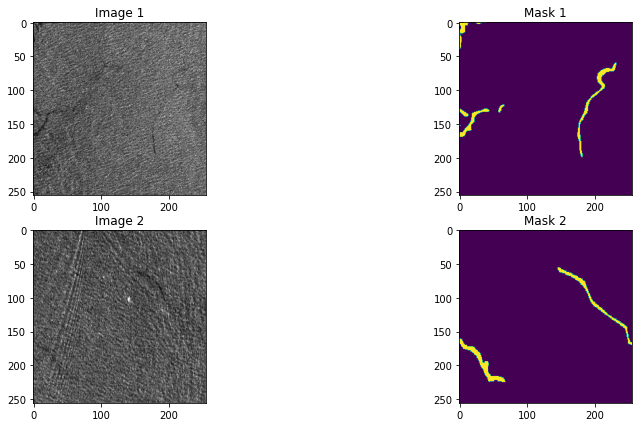

In [10]:
#Visualizing train set
print('Train images')
images, masks = next(iter(train_loader))

fig, axes = plt.subplots(figsize=(14, 7), ncols=2, nrows=2)
for index in range(2):
    axes[index][0].imshow(images[index].numpy().transpose((1,2,0)), cmap='gray')
    axes[index][0].set_title("Image {}".format(index + 1))
    axes[index][1].imshow(masks[index].numpy().transpose((1,2,0)))
    axes[index][1].set_title("Mask {}".format(index + 1))

Validation images


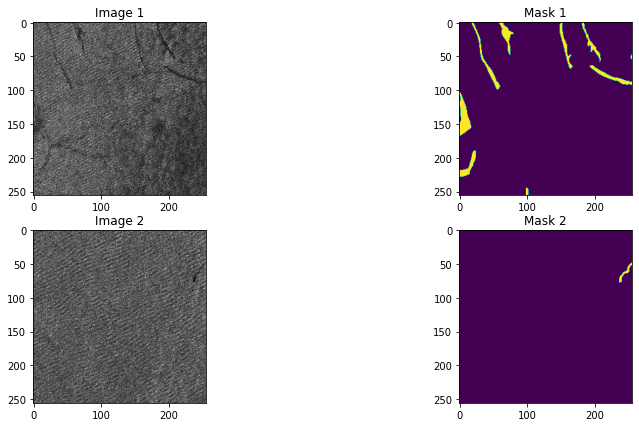

In [11]:
#Visualizing validation set
print('Validation images')
images, masks = next(iter(val_loader))

fig, axes = plt.subplots(figsize=(14, 7), ncols=2, nrows=2)
for index in range(2):
    axes[index][0].imshow(images[index].numpy().transpose((1,2,0)), cmap='gray')
    axes[index][0].set_title("Image {}".format(index + 1))
    axes[index][1].imshow(masks[index].numpy().transpose((1,2,0)))
    axes[index][1].set_title("Mask {}".format(index + 1))

## Modeling: Creating Neural Network model for training

In [12]:
# Model Declaration: UNet
# Extracted from https://www.kaggle.com/dhananjay3/image-segmentation-from-scratch-in-pytorch
class double_conv(nn.Module):
    """(conv => BN => ReLU) * 2"""

    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(nn.MaxPool2d(2), double_conv(in_ch, out_ch))

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2))
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256, False)
        self.up2 = up(512, 128, False)
        self.up3 = up(256, 64, False)
        self.up4 = up(128, 64, False)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return torch.sigmoid(x)

## Metrics: Jaccard index and Dice score  

In [13]:
# Extracted from: https://www.kaggle.com/dhananjay3/image-segmentation-from-scratch-in-pytorch
def f_score(pr, gt, beta=1, eps=1e-7, threshold=None, activation='sigmoid'):
    """
    Args:
        pr (torch.Tensor): A list of predicted elements
        gt (torch.Tensor):  A list of elements that are to be predicted
        eps (float): epsilon to avoid zero division
        threshold: threshold for outputs binarization
    Returns:
        float: IoU (Jaccard) score
    """

    if activation is None or activation == "none":
        activation_fn = lambda x: x
    elif activation == "sigmoid":
        activation_fn = torch.nn.Sigmoid()
    elif activation == "softmax2d":
        activation_fn = torch.nn.Softmax2d()
    else:
        raise NotImplementedError(
            "Activation implemented for sigmoid and softmax2d"
        )

    pr = activation_fn(pr)

    if threshold is not None:
        pr = (pr > threshold).float()


    tp = torch.sum(gt * pr)
    fp = torch.sum(pr) - tp
    fn = torch.sum(gt) - tp

    score = ((1 + beta ** 2) * tp + eps) \
            / ((1 + beta ** 2) * tp + beta ** 2 * fn + fp + eps)

    return score


class DiceLoss(nn.Module):
    __name__ = 'dice_loss'

    def __init__(self, eps=1e-7, activation='sigmoid'):
        super().__init__()
        self.activation = activation
        self.eps = eps

    def forward(self, y_pr, y_gt):
        jaccard = f_score(y_pr, y_gt, beta=1., 
                           eps=self.eps, threshold=None, 
                           activation=self.activation)
        dice = 2 * jaccard / (jaccard + 1)
        return 1 - dice


class BCEDiceLoss(DiceLoss):
    __name__ = 'bce_dice_loss'

    def __init__(self, eps=1e-7, activation='sigmoid', lambda_dice=1.0, lambda_bce=1.0):
        super().__init__(eps, activation)
        if activation == None:
            self.bce = nn.BCELoss(reduction='mean')
        else:
            self.bce = nn.BCEWithLogitsLoss(reduction='mean')
        self.lambda_dice=lambda_dice
        self.lambda_bce=lambda_bce

    def forward(self, y_pr, y_gt):
        dice = super().forward(y_pr, y_gt)
        bce = self.bce(y_pr, y_gt)
        return (self.lambda_dice*dice) + (self.lambda_bce* bce)

In [14]:
#Creating model and its parameters
num_classes = 1
input_channels = 1
model = UNet(n_classes=num_classes, n_channels=input_channels)

In [15]:
#Setting model hyperparameters
lr = 0.005
optimizer = optim.Adam(list(model.parameters()), lr=lr)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=2, cooldown=2)

In [16]:
#Creating loss criterion for model
criterion = BCEDiceLoss(eps=1.0, activation=None)

In [17]:
# Setting device and sending model to device
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print("Training using {}".format(device))
model.to(device)

Training using cuda:1


UNet(
  (inc): inconv(
    (conv): double_conv(
      (conv): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
  )
  (down1): down(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): double_conv(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2

## Training Loop

In [18]:
#Model training scope

n_epochs = 100
train_loss_list = []
train_dice_list = []
train_jaccard_list =[]
valid_loss_list = []
valid_dice_list = []
valid_jaccard_list = []
lr_rate_list = []
valid_loss_min, valid_dice_max, valid_jaccard_max = np.Inf, np.Inf, np.Inf

for epoch in range(1, n_epochs+1):
    train_loss = 0.0
    train_jaccard = 0.0
    train_dice = 0.0
    valid_loss = 0.0
    valid_jaccard = 0.0
    valid_dice = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    bar = tqdm(train_loader, postfix={"train_loss":0.0})
    for data, target in bar:
        
        data = data.to(device)
        target = target.to(device)
        
        optimizer.zero_grad()
        
        pred = model(data)
        loss = criterion(pred, target)
        loss.backward()
        optimizer.step()
        
        jaccard = f_score(pred.cpu(), target.cpu(), activation=None).item()
        dice = 2. * jaccard / (1. + jaccard)
        
        train_loss += loss.item()*data.size(0)
        train_jaccard += jaccard * data.size(0)
        train_dice += dice * data.size(0)
        
        bar.set_postfix(ordered_dict={"train_loss":loss.item()})
    ######################    
    # validate the model #
    ######################
    model.eval()
    del data, target
    with torch.no_grad():
        bar = tqdm(val_loader, postfix={"valid_loss":0.0, "dice_score":0.0, "jaccard_score":0.0})
        for data, target in bar:
            
            data = data.to(device)
            target = target.to(device)
            
            pred = model(data)
            
            loss = criterion(pred, target)
            valid_loss += loss.item()*data.size(0)
            
            jaccard = f_score(pred.cpu(), target.cpu(), activation=None).item()
            valid_jaccard += jaccard * data.size(0)
            
            dice = 2 * jaccard / (jaccard + 1)
            valid_dice +=  dice * data.size(0)
            
            bar.set_postfix(ordered_dict={"valid_loss":loss.item(), "dice_score":dice, "jaccard_score":jaccard})
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    train_jaccard = train_jaccard/len(train_loader.dataset)
    train_dice = train_dice/len(train_loader.dataset)
    valid_loss = valid_loss/len(val_loader.dataset)
    valid_jaccard = valid_jaccard/len(val_loader.dataset)
    valid_dice = valid_dice/len(val_loader.dataset)
    
    #Append it to history
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    train_jaccard_list.append(train_jaccard)
    valid_jaccard_list.append(valid_jaccard)
    train_dice_list.append(train_dice)
    valid_dice_list.append(valid_dice)
    
    lr_rate_list.append([param_group['lr'] for param_group in optimizer.param_groups])
    
    # print training/validation statistics 
    print('Epoch: {}/{}  Training Loss: {:.6f}  Validation Loss: {:.6f} Dice Score: {:.6f}  Jaccard Score: {:.6f}'.format(
        epoch, n_epochs, train_loss, valid_loss, valid_dice, valid_jaccard))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), "models/UNet-{}epochs.pth".format(n_epochs))
        valid_loss_min = valid_loss
        valid_dice_max = valid_dice
        valid_jaccard_max = valid_jaccard
    
    scheduler.step(valid_loss)

print('Training phase done!  Min Validation Loss: {:.6f}  Max Validation Dice Coefficient: {:.6f} Max Validation Jaccard Coefficient: {:.6f}'.format(
        valid_loss_min, valid_dice_max, valid_jaccard_max))

  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 1/100  Training Loss: 1.123422  Validation Loss: 1.070919 Dice Score: 0.081489  Jaccard Score: 0.042740
Validation loss decreased (inf --> 1.070919).  Saving model ...


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 2/100  Training Loss: 0.908299  Validation Loss: 0.780275 Dice Score: 0.306156  Jaccard Score: 0.183615
Validation loss decreased (1.070919 --> 0.780275).  Saving model ...


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 3/100  Training Loss: 0.829417  Validation Loss: 0.766483 Dice Score: 0.322013  Jaccard Score: 0.192986
Validation loss decreased (0.780275 --> 0.766483).  Saving model ...


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 4/100  Training Loss: 0.797162  Validation Loss: 0.765663 Dice Score: 0.327834  Jaccard Score: 0.201603
Validation loss decreased (0.766483 --> 0.765663).  Saving model ...


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 5/100  Training Loss: 0.780140  Validation Loss: 0.871645 Dice Score: 0.297532  Jaccard Score: 0.176835


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 6/100  Training Loss: 0.731256  Validation Loss: 1.169601 Dice Score: 0.249520  Jaccard Score: 0.145486


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 7/100  Training Loss: 0.790580  Validation Loss: 0.790173 Dice Score: 0.332411  Jaccard Score: 0.201977


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 8/100  Training Loss: 0.738041  Validation Loss: 0.662257 Dice Score: 0.427701  Jaccard Score: 0.277223
Validation loss decreased (0.765663 --> 0.662257).  Saving model ...


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 9/100  Training Loss: 0.681763  Validation Loss: 0.642656 Dice Score: 0.443624  Jaccard Score: 0.289088
Validation loss decreased (0.662257 --> 0.642656).  Saving model ...


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 10/100  Training Loss: 0.648686  Validation Loss: 0.652598 Dice Score: 0.444848  Jaccard Score: 0.295132


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 11/100  Training Loss: 0.630149  Validation Loss: 0.586723 Dice Score: 0.506657  Jaccard Score: 0.348313
Validation loss decreased (0.642656 --> 0.586723).  Saving model ...


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 12/100  Training Loss: 0.604284  Validation Loss: 0.557639 Dice Score: 0.524853  Jaccard Score: 0.358858
Validation loss decreased (0.586723 --> 0.557639).  Saving model ...


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 13/100  Training Loss: 0.578963  Validation Loss: 0.570974 Dice Score: 0.528147  Jaccard Score: 0.363947


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 14/100  Training Loss: 0.557385  Validation Loss: 0.547546 Dice Score: 0.532560  Jaccard Score: 0.369145
Validation loss decreased (0.557639 --> 0.547546).  Saving model ...


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 15/100  Training Loss: 0.534605  Validation Loss: 0.510161 Dice Score: 0.581438  Jaccard Score: 0.414384
Validation loss decreased (0.547546 --> 0.510161).  Saving model ...


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 16/100  Training Loss: 0.524754  Validation Loss: 0.501213 Dice Score: 0.589226  Jaccard Score: 0.422780
Validation loss decreased (0.510161 --> 0.501213).  Saving model ...


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 17/100  Training Loss: 0.516803  Validation Loss: 0.539848 Dice Score: 0.554668  Jaccard Score: 0.387009


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 18/100  Training Loss: 0.492358  Validation Loss: 0.538003 Dice Score: 0.547483  Jaccard Score: 0.386197


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 19/100  Training Loss: 0.512125  Validation Loss: 0.524341 Dice Score: 0.569164  Jaccard Score: 0.404314


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 20/100  Training Loss: 0.490362  Validation Loss: 0.482493 Dice Score: 0.606031  Jaccard Score: 0.441926
Validation loss decreased (0.501213 --> 0.482493).  Saving model ...


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 21/100  Training Loss: 0.488064  Validation Loss: 0.473455 Dice Score: 0.607441  Jaccard Score: 0.440363
Validation loss decreased (0.482493 --> 0.473455).  Saving model ...


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 22/100  Training Loss: 0.468705  Validation Loss: 0.491918 Dice Score: 0.600204  Jaccard Score: 0.434395


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 23/100  Training Loss: 0.472845  Validation Loss: 0.529382 Dice Score: 0.565272  Jaccard Score: 0.403522


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 24/100  Training Loss: 0.473184  Validation Loss: 0.487372 Dice Score: 0.599922  Jaccard Score: 0.435590


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 25/100  Training Loss: 0.470561  Validation Loss: 0.499104 Dice Score: 0.590609  Jaccard Score: 0.423328


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 26/100  Training Loss: 0.457079  Validation Loss: 0.479696 Dice Score: 0.603743  Jaccard Score: 0.436397


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 27/100  Training Loss: 0.466108  Validation Loss: 0.479554 Dice Score: 0.605192  Jaccard Score: 0.438392


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 28/100  Training Loss: 0.458717  Validation Loss: 0.473933 Dice Score: 0.614087  Jaccard Score: 0.445158


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 29/100  Training Loss: 0.459697  Validation Loss: 0.458200 Dice Score: 0.630102  Jaccard Score: 0.463492
Validation loss decreased (0.473455 --> 0.458200).  Saving model ...


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 30/100  Training Loss: 0.460636  Validation Loss: 0.466621 Dice Score: 0.615425  Jaccard Score: 0.449961


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 31/100  Training Loss: 0.465146  Validation Loss: 0.472230 Dice Score: 0.617533  Jaccard Score: 0.448190


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 32/100  Training Loss: 0.445395  Validation Loss: 0.473511 Dice Score: 0.601899  Jaccard Score: 0.433916


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 33/100  Training Loss: 0.456914  Validation Loss: 0.463901 Dice Score: 0.623123  Jaccard Score: 0.453888


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 34/100  Training Loss: 0.472432  Validation Loss: 0.504405 Dice Score: 0.584943  Jaccard Score: 0.420657


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 35/100  Training Loss: 0.481644  Validation Loss: 0.504614 Dice Score: 0.588389  Jaccard Score: 0.420387


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 36/100  Training Loss: 0.460767  Validation Loss: 0.502010 Dice Score: 0.593391  Jaccard Score: 0.434973


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 37/100  Training Loss: 0.462009  Validation Loss: 0.478203 Dice Score: 0.610806  Jaccard Score: 0.444738


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 38/100  Training Loss: 0.467991  Validation Loss: 0.455109 Dice Score: 0.624871  Jaccard Score: 0.461380
Validation loss decreased (0.458200 --> 0.455109).  Saving model ...


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 39/100  Training Loss: 0.457913  Validation Loss: 0.472619 Dice Score: 0.612082  Jaccard Score: 0.447060


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 40/100  Training Loss: 0.464844  Validation Loss: 0.453527 Dice Score: 0.630366  Jaccard Score: 0.464519
Validation loss decreased (0.455109 --> 0.453527).  Saving model ...


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 41/100  Training Loss: 0.479970  Validation Loss: 0.490723 Dice Score: 0.597083  Jaccard Score: 0.432077


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 42/100  Training Loss: 0.476110  Validation Loss: 0.490704 Dice Score: 0.598302  Jaccard Score: 0.432590


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 43/100  Training Loss: 0.452123  Validation Loss: 0.470017 Dice Score: 0.611510  Jaccard Score: 0.446200


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 44/100  Training Loss: 0.467638  Validation Loss: 0.474460 Dice Score: 0.612067  Jaccard Score: 0.448158


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 45/100  Training Loss: 0.445856  Validation Loss: 0.470440 Dice Score: 0.613596  Jaccard Score: 0.450391


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 46/100  Training Loss: 0.467216  Validation Loss: 0.492705 Dice Score: 0.594312  Jaccard Score: 0.424637


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 47/100  Training Loss: 0.457619  Validation Loss: 0.475498 Dice Score: 0.614923  Jaccard Score: 0.449402


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 48/100  Training Loss: 0.482757  Validation Loss: 0.450300 Dice Score: 0.633545  Jaccard Score: 0.468967
Validation loss decreased (0.453527 --> 0.450300).  Saving model ...


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 49/100  Training Loss: 0.463031  Validation Loss: 0.458763 Dice Score: 0.623044  Jaccard Score: 0.457947


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 50/100  Training Loss: 0.463663  Validation Loss: 0.447934 Dice Score: 0.636114  Jaccard Score: 0.471226
Validation loss decreased (0.450300 --> 0.447934).  Saving model ...


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 51/100  Training Loss: 0.467996  Validation Loss: 0.429824 Dice Score: 0.652337  Jaccard Score: 0.489013
Validation loss decreased (0.447934 --> 0.429824).  Saving model ...


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 52/100  Training Loss: 0.459935  Validation Loss: 0.473464 Dice Score: 0.609586  Jaccard Score: 0.441975


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 53/100  Training Loss: 0.470899  Validation Loss: 0.473700 Dice Score: 0.620320  Jaccard Score: 0.452040


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 54/100  Training Loss: 0.462864  Validation Loss: 0.471117 Dice Score: 0.616620  Jaccard Score: 0.450369


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 55/100  Training Loss: 0.460541  Validation Loss: 0.476428 Dice Score: 0.609219  Jaccard Score: 0.446446


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 56/100  Training Loss: 0.477392  Validation Loss: 0.469386 Dice Score: 0.616916  Jaccard Score: 0.448146


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 57/100  Training Loss: 0.476524  Validation Loss: 0.467620 Dice Score: 0.616158  Jaccard Score: 0.451240


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 58/100  Training Loss: 0.455583  Validation Loss: 0.482329 Dice Score: 0.600399  Jaccard Score: 0.436746


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 59/100  Training Loss: 0.468771  Validation Loss: 0.455148 Dice Score: 0.626542  Jaccard Score: 0.458575


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 60/100  Training Loss: 0.459895  Validation Loss: 0.488645 Dice Score: 0.599486  Jaccard Score: 0.432196


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 61/100  Training Loss: 0.459482  Validation Loss: 0.461313 Dice Score: 0.621172  Jaccard Score: 0.455276


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 62/100  Training Loss: 0.463158  Validation Loss: 0.479306 Dice Score: 0.606504  Jaccard Score: 0.441394


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 63/100  Training Loss: 0.486674  Validation Loss: 0.464580 Dice Score: 0.623224  Jaccard Score: 0.455119


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 64/100  Training Loss: 0.467901  Validation Loss: 0.468824 Dice Score: 0.614022  Jaccard Score: 0.449700


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 65/100  Training Loss: 0.447775  Validation Loss: 0.458330 Dice Score: 0.619203  Jaccard Score: 0.451093


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 66/100  Training Loss: 0.455507  Validation Loss: 0.483371 Dice Score: 0.597737  Jaccard Score: 0.430914


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 67/100  Training Loss: 0.465583  Validation Loss: 0.479948 Dice Score: 0.611715  Jaccard Score: 0.444418


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 68/100  Training Loss: 0.467161  Validation Loss: 0.459636 Dice Score: 0.622223  Jaccard Score: 0.456569


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 69/100  Training Loss: 0.460177  Validation Loss: 0.456470 Dice Score: 0.623177  Jaccard Score: 0.459305


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 70/100  Training Loss: 0.469694  Validation Loss: 0.450041 Dice Score: 0.634420  Jaccard Score: 0.470383


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 71/100  Training Loss: 0.465990  Validation Loss: 0.455019 Dice Score: 0.622091  Jaccard Score: 0.456971


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 72/100  Training Loss: 0.457553  Validation Loss: 0.456998 Dice Score: 0.626386  Jaccard Score: 0.461268


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 73/100  Training Loss: 0.487069  Validation Loss: 0.478522 Dice Score: 0.606134  Jaccard Score: 0.440460


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 74/100  Training Loss: 0.479867  Validation Loss: 0.481913 Dice Score: 0.608910  Jaccard Score: 0.440366


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 75/100  Training Loss: 0.468664  Validation Loss: 0.453842 Dice Score: 0.628311  Jaccard Score: 0.463198


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 76/100  Training Loss: 0.440701  Validation Loss: 0.452846 Dice Score: 0.628232  Jaccard Score: 0.460970


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 77/100  Training Loss: 0.464232  Validation Loss: 0.522686 Dice Score: 0.567754  Jaccard Score: 0.402099


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 78/100  Training Loss: 0.458361  Validation Loss: 0.487502 Dice Score: 0.602328  Jaccard Score: 0.437042


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 79/100  Training Loss: 0.463438  Validation Loss: 0.459043 Dice Score: 0.619874  Jaccard Score: 0.452779


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 80/100  Training Loss: 0.465868  Validation Loss: 0.478142 Dice Score: 0.612614  Jaccard Score: 0.448295


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 81/100  Training Loss: 0.454479  Validation Loss: 0.484097 Dice Score: 0.608383  Jaccard Score: 0.440541


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 82/100  Training Loss: 0.452514  Validation Loss: 0.469610 Dice Score: 0.620292  Jaccard Score: 0.452800


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 83/100  Training Loss: 0.469902  Validation Loss: 0.478120 Dice Score: 0.610568  Jaccard Score: 0.439994


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 84/100  Training Loss: 0.444017  Validation Loss: 0.444049 Dice Score: 0.635026  Jaccard Score: 0.467550


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 85/100  Training Loss: 0.460215  Validation Loss: 0.463613 Dice Score: 0.619085  Jaccard Score: 0.450888


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 86/100  Training Loss: 0.470797  Validation Loss: 0.471853 Dice Score: 0.615503  Jaccard Score: 0.448329


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 87/100  Training Loss: 0.450808  Validation Loss: 0.485780 Dice Score: 0.603751  Jaccard Score: 0.437556


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 88/100  Training Loss: 0.452335  Validation Loss: 0.473952 Dice Score: 0.611659  Jaccard Score: 0.448505


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 89/100  Training Loss: 0.457564  Validation Loss: 0.507688 Dice Score: 0.583397  Jaccard Score: 0.419823


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 90/100  Training Loss: 0.463813  Validation Loss: 0.456585 Dice Score: 0.625467  Jaccard Score: 0.463397


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 91/100  Training Loss: 0.455945  Validation Loss: 0.488732 Dice Score: 0.600025  Jaccard Score: 0.436276


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 92/100  Training Loss: 0.473679  Validation Loss: 0.451017 Dice Score: 0.628792  Jaccard Score: 0.461969


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 93/100  Training Loss: 0.468892  Validation Loss: 0.441491 Dice Score: 0.638623  Jaccard Score: 0.471115


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 94/100  Training Loss: 0.467773  Validation Loss: 0.444768 Dice Score: 0.637857  Jaccard Score: 0.474538


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 95/100  Training Loss: 0.451519  Validation Loss: 0.483231 Dice Score: 0.604795  Jaccard Score: 0.435773


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 96/100  Training Loss: 0.465099  Validation Loss: 0.465540 Dice Score: 0.621120  Jaccard Score: 0.455472


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 97/100  Training Loss: 0.462633  Validation Loss: 0.506401 Dice Score: 0.586088  Jaccard Score: 0.419208


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 98/100  Training Loss: 0.460757  Validation Loss: 0.447660 Dice Score: 0.635830  Jaccard Score: 0.470778


  0%|          | 0/35 [00:00<?, ?it/s, train_loss=0]

Epoch: 99/100  Training Loss: 0.458502  Validation Loss: 0.463458 Dice Score: 0.624530  Jaccard Score: 0.458844


100%|██████████| 10/10 [00:01<00:00,  6.81it/s, valid_loss=0.519, dice_score=0.539, jaccard_score=0.369]

Epoch: 100/100  Training Loss: 0.471183  Validation Loss: 0.489277 Dice Score: 0.599859  Jaccard Score: 0.433099
Training phase done!  Min Validation Loss: 0.429824  Max Validation Dice Coefficient: 0.652337 Max Validation Jaccard Coefficient: 0.489013


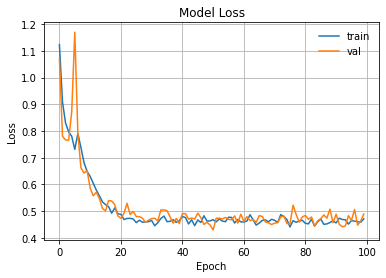

In [19]:
# Plotting training and validation losses
plt.plot(train_loss_list,label='train')
plt.plot(valid_loss_list, label='val')
plt.legend(frameon=False)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.title("Model Loss")
plt.show()

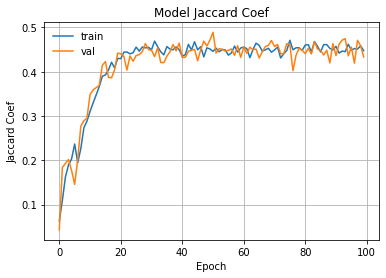

In [20]:
# Plotting training and validation Jaccard Coef. (IoU)
plt.plot(train_jaccard_list,label='train')
plt.plot(valid_jaccard_list, label='val')
plt.legend(frameon=False)
plt.xlabel('Epoch')
plt.ylabel('Jaccard Coef')
plt.grid()
plt.title("Model Jaccard Coef")
plt.show()

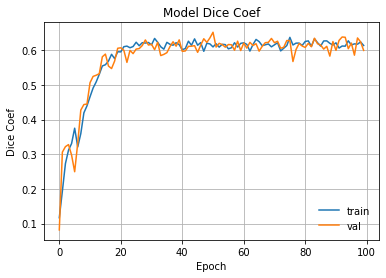

In [21]:
# Plotting training and validation Dice Coefficient
plt.plot(train_dice_list,label='train')
plt.plot(valid_dice_list, label='val')
plt.legend(frameon=False)
plt.xlabel('Epoch')
plt.ylabel('Dice Coef')
plt.grid()
plt.title("Model Dice Coef")
plt.show()

## Testing the model

In [22]:
#Load best model
model.load_state_dict(torch.load('models/UNet-100epochs.pth'))

<All keys matched successfully>

In [23]:
#Create test loader
test_loader = make_loader(X_test, transforms=transforms)

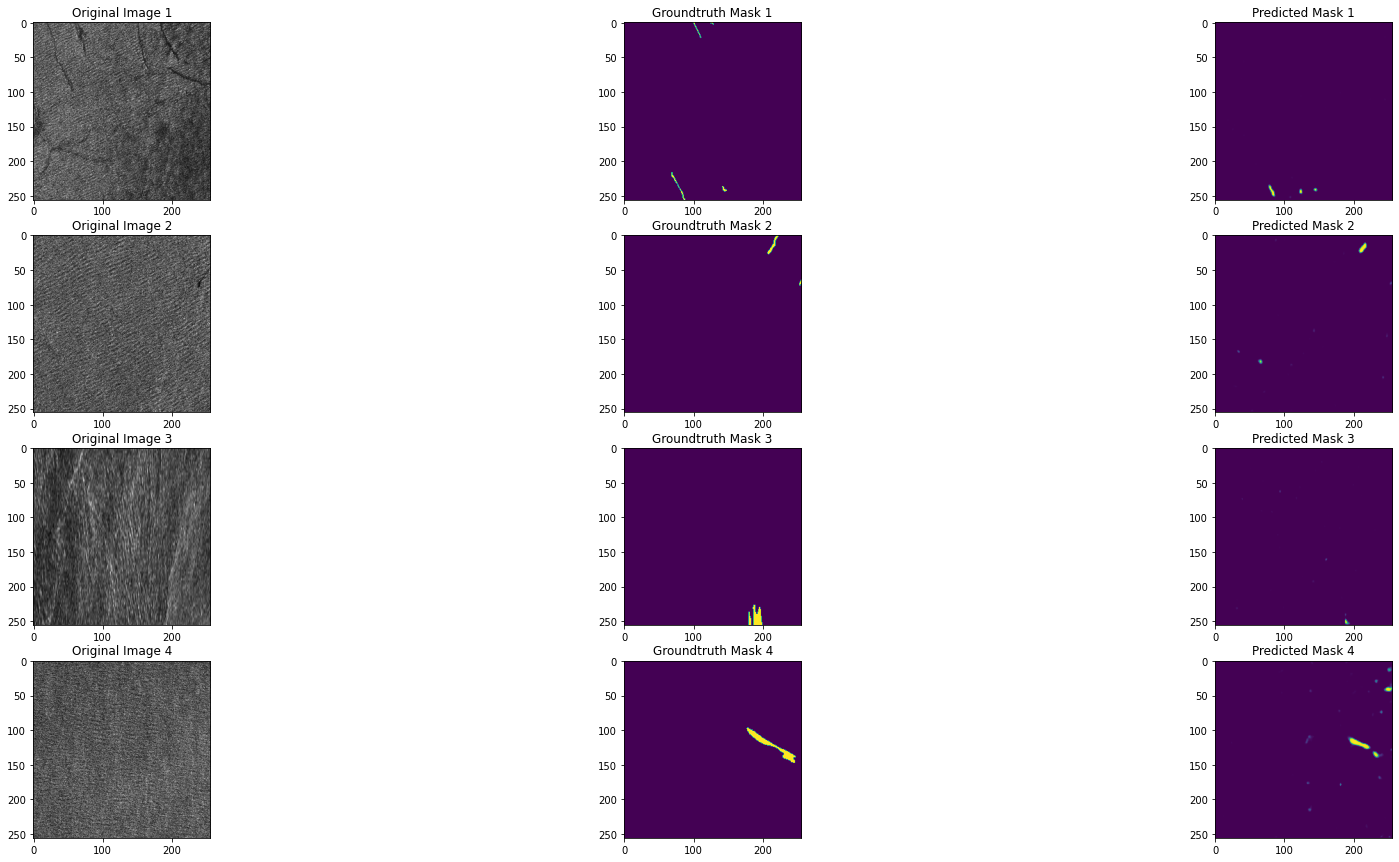

In [24]:
#Visualizing test set and predictions
imgs, masks = next(iter(test_loader))

fig, axes = plt.subplots(figsize=(30,15), ncols=3, nrows=4)
for index in range(4):
    axes[index][0].imshow(images[index].numpy().transpose((1,2,0)), cmap='gray')
    axes[index][0].set_title("Original Image {}".format(index + 1))
    
    axes[index][1].imshow(masks[index].numpy().transpose((1,2,0)))
    axes[index][1].set_title("Groundtruth Mask {}".format(index + 1))
    
    #Generating label from trained model
    label = model(imgs[index].unsqueeze(0).to(device).float())
    label = label.cpu().detach().numpy()
    label = label.squeeze()
    
    axes[index][2].imshow(label)
    axes[index][2].set_title("Predicted Mask {}".format(index + 1))

In [25]:
# Test loop
dice_results = []
jaccard_results = []

for data, target in tqdm(test_loader):
    data = data.to(device)
    target = target.to(device)

    with torch.no_grad():
        pred = model(data)
        jaccard = f_score(pred, target, activation=None)
        dice = 2 * jaccard / (jaccard + 1)
        dice_results += [dice.data.cpu().numpy()]
        jaccard_results += [jaccard.data.cpu().numpy()]

print("Testing Statistics\n")
print("Test Dice = ", np.mean(dice_results))
print("Test Jaccard (mIoU) = ", np.mean(jaccard_results))

100%|██████████| 20/20 [00:00<00:00, 28.32it/s]

Testing Statistics

Test Dice =  0.53089714
Test Jaccard (mIoU) =  0.3856979


In [26]:
torch.save(model.state_dict(), "models/UNet-{}epochs-{}class-{}dice.pth".format(n_epochs, num_classes, int(np.mean(dice_results) * 100)))